Notebook para comparar los modelos hechos del dataset ponderado (P2)

- **Tarea del backlog:** https://github.com/UCM-GIDIA-PD1/c2425-R4/issues/46
- **Propósito del código:** Comparaciones de los modelos del dataframe de peleas ponderadas (P2).
- **Autor(es):** Carlos Vallejo.  
- **Descripción y uso:** El objetivo de este notebook es ver que modelo nos da el resultado más óptimo.

In [87]:
import os
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,log_loss, f1_score, roc_auc_score, precision_score, recall_score, make_scorer, balanced_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
import mlflow
import optuna
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.tree import plot_tree


### Carga y preprocesamiento de los datos

Esta fase es global

In [88]:
ruta_train =  os.path.join("..","..","..", "data", "P2","train.parquet")
train = pd.read_parquet(ruta_train)

ruta_test =  os.path.join("..","..","..", "data", "P2","test.parquet")
test = pd.read_parquet(ruta_test)

test.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Puntos_A,Puntos_B,Peleas_A,Peleas_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF
0,2022-11-19,Kennedy Nzechukwu,Ion Cutelaba,False,0.00,0.40,0.4176,0.5208,0.2556,0.8640,...,86.483419,0.000000,7,13,-0.4,-0.1032,-0.110729,0.36,0.00,-39.60
1,2022-11-19,Vince Morales,Miles Johns,True,0.24,0.64,0.4028,0.4848,0.1000,0.0000,...,69.390238,54.933053,7,5,-0.4,-0.0820,0.153846,0.00,0.36,-52.16
2,2022-11-19,Andre Fialho,Muslim Salikhov,True,0.64,0.24,0.5220,0.4524,0.0000,0.2484,...,64.524204,127.265131,4,7,0.4,0.0696,-0.192661,0.00,0.00,-54.80
3,2022-11-19,Jennifer Maia,Maryna Moroz,False,0.00,0.00,0.3240,0.4880,0.0900,0.2480,...,15.229011,37.550440,9,9,0.0,-0.1640,-0.069020,-1.08,0.00,-340.04
4,2022-12-03,Eryk Anders,Kyle Daukaus,False,0.00,0.00,0.4532,0.5928,0.0432,0.2000,...,0.000000,58.874428,14,6,0.0,-0.1396,-0.158176,-1.68,0.40,189.72


## BASELINE

Como modelo base creamos un modelo que predice que gana el peleador que más puntos tenga.

In [ ]:
columnasQuitar = ["DATE","Peleador_A","Peleador_B", "WINNER"]

X_train_baseline = train.drop(columns=columnasQuitar)
y_train_baseline = train['WINNER']
X_test_baseline = test.drop(columns=columnasQuitar)
y_test_baseline = test['WINNER']

y_pred_baseline = (X_test_baseline["Puntos_A"] - X_test_baseline["Puntos_B"]) < 0

print("Reporte de clasificación baseline:")
print(classification_report(y_test_baseline, y_pred_baseline))


              precision    recall  f1-score   support

       False       0.58      0.62      0.60       349
        True       0.51      0.46      0.48       290

    accuracy                           0.55       639
   macro avg       0.54      0.54      0.54       639
weighted avg       0.55      0.55      0.55       639



-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5508607198748043
F1-Score: 0.4829
AUC-ROC: 0.5434
Precisión: 0.5057
Sensibilidad: 0.4621
Log-loss: 2.220446049250313e-16
[[218 131]
 [156 134]]


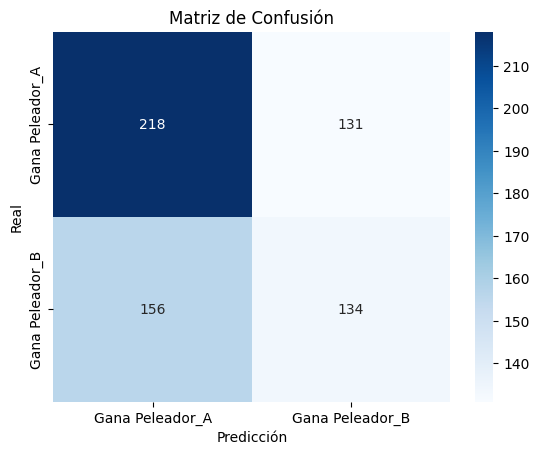

In [ ]:
print("-- Métricas del modelo base con hiperparámetros ajustados --")

print("Accuracy:", accuracy_score(y_test_baseline, y_pred_baseline))
f1_test = f1_score(y_test_baseline, y_pred_baseline)
roc_auc_test = roc_auc_score(y_test_baseline, y_pred_baseline)
precision_test = precision_score(y_test_baseline, y_pred_baseline)
recall_test = recall_score(y_test_baseline, y_pred_baseline)
log_loss_test = log_loss(y_test_baseline,y_test_baseline)
print(f"F1-Score: {f1_test:.4f}")
print(f"AUC-ROC: {roc_auc_test:.4f}")
print(f"Precisión: {precision_test:.4f}")
print(f"Sensibilidad: {recall_test:.4f}")
print(f"Log-loss: {log_loss_test}")
print(confusion_matrix(y_test_baseline, y_pred_baseline))

cm = confusion_matrix(y_test_baseline, y_pred_baseline)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Gana Peleador_A', 'Gana Peleador_B'], yticklabels=['Gana Peleador_A', 'Gana Peleador_B'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Baseline')
plt.show()

## Árbol de decisión

Primero seleccionamos las variables a utilizar. En el caso del árbol escogemos todas excepto los nombres de los peleadores y la fecha de la pelea.

In [91]:
columnasQuitar = ["DATE","Peleador_A","Peleador_B", "WINNER"]

X_train_arbol = train.drop(columns=columnasQuitar)
y_train_arbol = train['WINNER']
X_test_arbol = test.drop(columns=columnasQuitar)
y_test_arbol = test['WINNER']

Ahora creamos el modelo teniendo en cuenta los hiperparámetros utilizados para crear el modelo más óptimo.

Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.55      0.68      0.61       349
        True       0.47      0.34      0.39       290

    accuracy                           0.53       639
   macro avg       0.51      0.51      0.50       639
weighted avg       0.52      0.53      0.51       639

Variables con importancia en el modelo: CTRL_A, Importancia: 0.13969
Variables con importancia en el modelo: STR_HEAD_B_x, Importancia: 0.27398
Variables con importancia en el modelo: GRAPPLER_A, Importancia: 0.16357
Variables con importancia en el modelo: Victorias_Decision_B, Importancia: 0.07930
Variables con importancia en el modelo: Racha_A, Importancia: 0.24435
Variables con importancia en el modelo: Puntos_B, Importancia: 0.09910


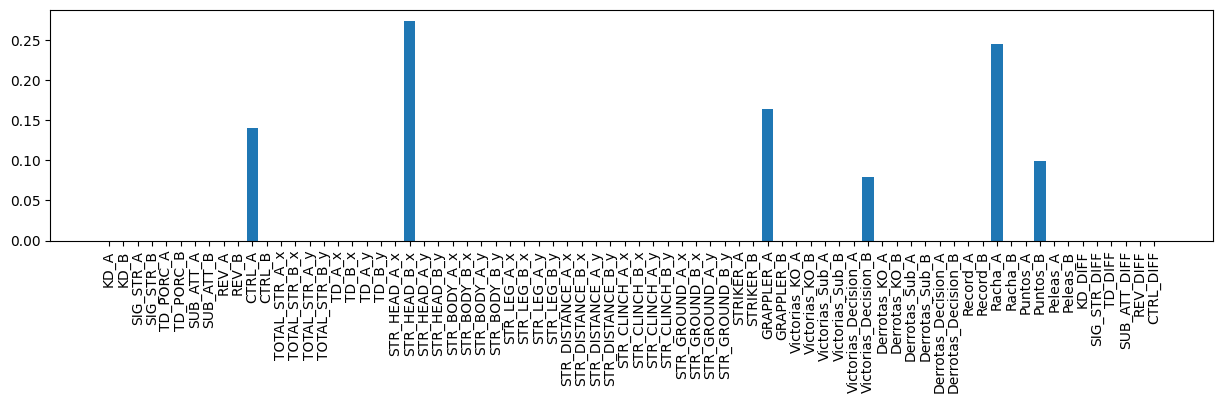

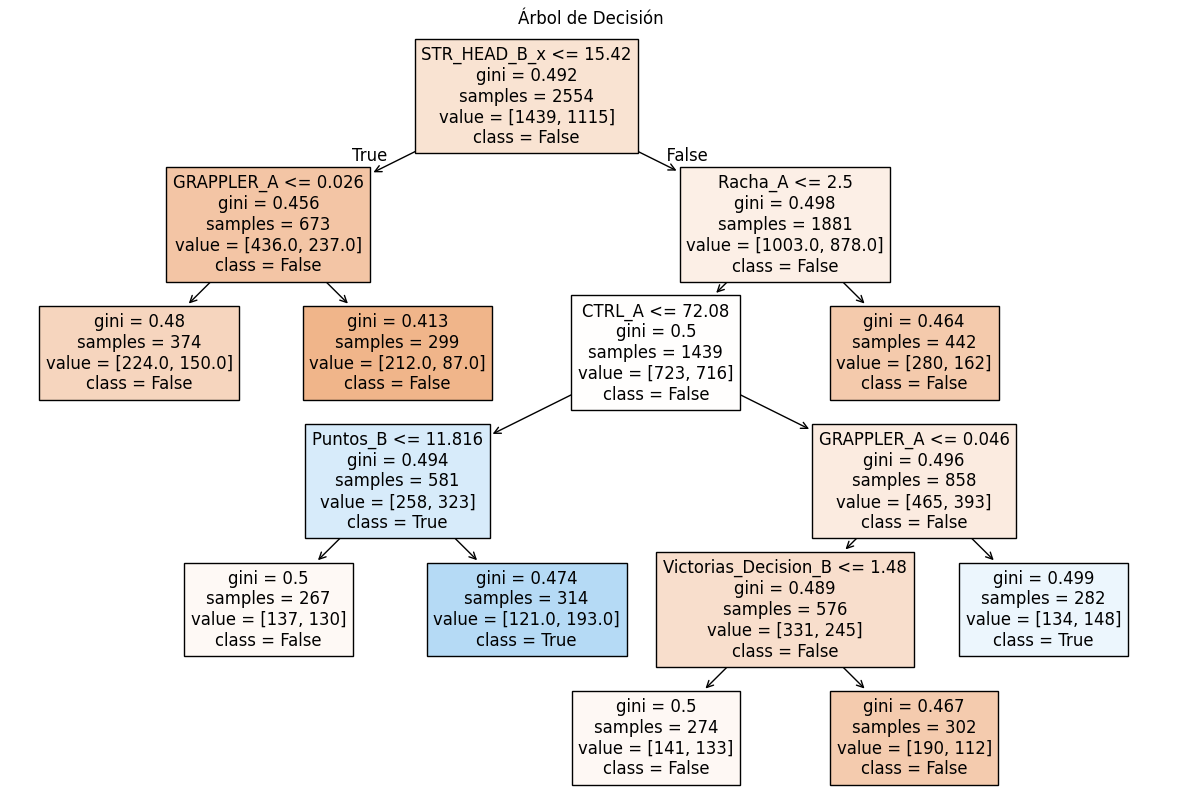

In [ ]:
# Definir modelo base
arbol = DecisionTreeClassifier(
    criterion = 'gini',  # Función para medir la calidad de la división
    max_depth = 5,  # Profundidad máxima del árbol
    min_samples_split = 2,  # Mínimo de muestras para dividir un nodo
    min_samples_leaf = 1,  # Mínimo de muestras en una hoja
    min_weight_fraction_leaf = 0.1,
    splitter = 'best',
    class_weight = None,  # Ajuste de pesos por clase
    max_features = None,
    random_state  =42    
)


# Entrenar el modelo
arbol.fit(X_train_arbol, y_train_arbol)

y_pred_arbol = arbol.predict(X_test_arbol)

print("Reporte de clasificación árbol de decisión:")
print(classification_report(y_test_arbol, y_pred_arbol))

importance = arbol.feature_importances_
feature_names=X_train_arbol.columns
for i,v in enumerate(importance):
	if v > 0:
	    print('Variables con importancia en el modelo: %s, Importancia: %.5f' % (feature_names[i],v))

#Visualización de las variables más importantes
plt.figure(figsize=(15, 3))
plt.bar([x for x in range(len(importance))], importance, tick_label = feature_names)
plt.xticks(rotation = 90)
plt.show()

#Visualización del árbol
plt.figure(figsize=(15, 10))
plot_tree(arbol, filled=True, feature_names=X_train_arbol.columns, class_names=[str(i) for i in np.unique(y_train_arbol)])
plt.title('Árbol de Decisión')
plt.show()


Viendo el modelo del árbol de decisión, observamos que hay dos variables que destacan por importancia sobre el resto, y que, no hay muchas variables con peso en el modelo. Esto resulta interesante para ver si estas variables tienen importancia parecida en los otros modelos. Ademas, como se puede ver en las métricas, este modelo es parecido al modelo base.

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5258215962441315
F1-Score: 0.3928
AUC-ROC: 0.5383
Precisión: 0.4689
Sensibilidad: 0.3379
Log-loss: 0.7004803201475847
[[238 111]
 [192  98]]


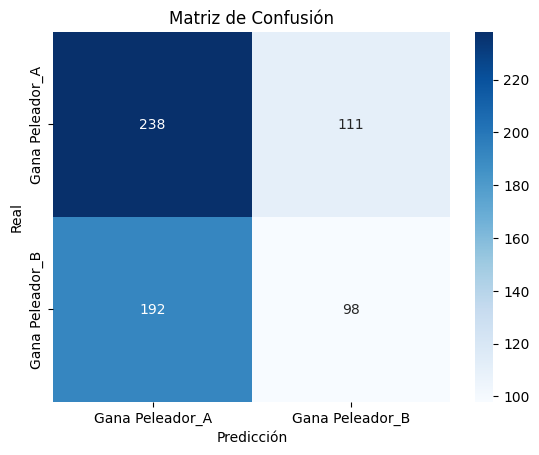

In [ ]:
print("-- Métricas del árbol de decisión con hiperparámetros ajustados --")
y_prob_arbol = arbol.predict_proba(X_test_arbol)[:,1]
print("Accuracy:", accuracy_score(y_test_arbol, y_pred_arbol))
f1_test = f1_score(y_test_arbol, y_pred_arbol)
roc_auc_test = roc_auc_score(y_test_arbol, y_prob_arbol)
precision_test = precision_score(y_test_arbol, y_pred_arbol)
recall_test = recall_score(y_test_arbol, y_pred_arbol)
log_loss_test = log_loss(y_test_arbol,y_prob_arbol)
print(f"F1-Score: {f1_test:.4f}")
print(f"AUC-ROC: {roc_auc_test:.4f}")
print(f"Precisión: {precision_test:.4f}")
print(f"Sensibilidad: {recall_test:.4f}")
print(f"Log-loss: {log_loss_test}")
print(confusion_matrix(y_test_arbol, y_pred_arbol))

cm = confusion_matrix(y_test_arbol, y_pred_arbol)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Gana Peleador_A', 'Gana Peleador_B'], yticklabels=['Gana Peleador_A', 'Gana Peleador_B'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Árbol de decisión')
plt.show()

## XGboost

Las variables seleccionadas son las mismas que en el árbol de decisión.

In [94]:
columnasQuitar = ["DATE","Peleador_A","Peleador_B", "WINNER"]

X_train_xgboost = train.drop(columns=columnasQuitar)
y_train_xgboost = train['WINNER']
X_test_xgboost = test.drop(columns=columnasQuitar)
y_test_xgboost = test['WINNER']

Creamos el modelo teniendo en cuenta los mejores parámetros obtenidos en el notebook "XGBoost_pond.ipynb"

In [ ]:
# Parámetros fijos
params = {
    'n_estimators': 350,
    'max_depth': 37,
    'learning_rate': 0.014525356301837976,
    'subsample': 0.6223758299538741,
    'colsample_bytree': 0.5603666759669468,
    'gamma': 0.4820740200787993,
    'min_child_weight': 31,
    'scale_pos_weight': 1.2905829596412555,
    'reg_alpha': 0.1,
    'tree_method': 'exact',
    'grow_policy': 'lossguide',
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

xgboost = XGBClassifier(**params)

xgboost.fit(X_train_xgboost, y_train_xgboost)

y_pred_xgboost = xgboost.predict(X_test_xgboost)

print("Reporte de clasificación xgboost:")
print(classification_report(y_test_xgboost, y_pred_xgboost))
print(f'Accuracy: {accuracy_score(y_test_xgboost, y_pred_xgboost):.4f}')
print(f"F1-score: {f1_score(y_test_xgboost,y_pred_xgboost)}")

Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.63      0.59      0.61       349
        True       0.54      0.58      0.56       290

    accuracy                           0.58       639
   macro avg       0.58      0.58      0.58       639
weighted avg       0.59      0.58      0.58       639

Accuracy: 0.5837
F1-score: 0.5581395348837209


-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5837245696400626
F1-Score: 0.5581
AUC-ROC: 0.6131
Precisión: 0.5385
Sensibilidad: 0.5793
Log-loss: 0.6754048219019672
[[205 144]
 [122 168]]


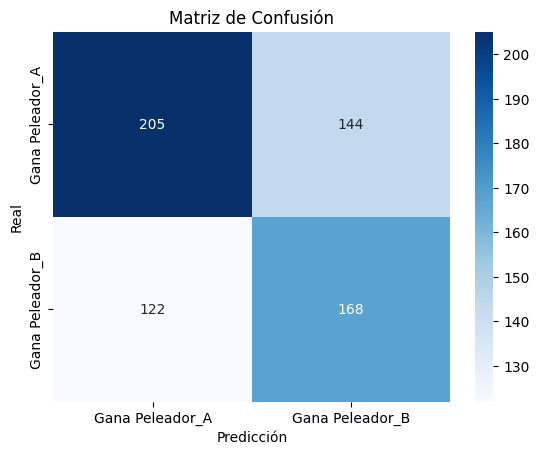

In [ ]:
print("-- Métricas del modelo de xgboost con hiperparámetros ajustados --")

print("Accuracy:", accuracy_score(y_test_xgboost, y_pred_xgboost))
y_prob_xgboost = xgboost.predict_proba(X_test_xgboost)[:,1]
f1_test = f1_score(y_test_xgboost, y_pred_xgboost)
roc_auc_test = roc_auc_score(y_test_xgboost, y_prob_xgboost)
precision_test = precision_score(y_test_xgboost, y_pred_xgboost)
recall_test = recall_score(y_test_xgboost, y_pred_xgboost)
log_loss_test = log_loss(y_test_xgboost,y_prob_xgboost)
print(f"F1-Score: {f1_test:.4f}")
print(f"AUC-ROC: {roc_auc_test:.4f}")
print(f"Precisión: {precision_test:.4f}")
print(f"Sensibilidad: {recall_test:.4f}")
print(f"Log-loss: {log_loss_test}")
print(confusion_matrix(y_test_xgboost, y_pred_xgboost))

cm = confusion_matrix(y_test_xgboost, y_pred_xgboost)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Gana Peleador_A', 'Gana Peleador_B'], yticklabels=['Gana Peleador_A', 'Gana Peleador_B'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Xgboost')
plt.show()

## Regresión logística

En regresión logística sí eliminamos variables (para ver el proceso, está en "regresion_logistica_P2_telmo.ipynb").

In [97]:
columnasQuitar = ["DATE","Peleador_A","Peleador_B", "WINNER",'TD_B_y', 'GRAPPLER_B', 'STR_CLINCH_A_y', 'GRAPPLER_A', 'STR_HEAD_B_y', 'TD_A_y', 'STR_BODY_B_y', 'STR_HEAD_B_x', 'STR_DISTANCE_A_x', 'STR_HEAD_A_y', 'TOTAL_STR_B_y', 'STR_HEAD_A_x', 'STR_DISTANCE_A_y', 'STR_CLINCH_B_y', 'TOTAL_STR_A_y', 'STR_GROUND_B_y', 'STR_DISTANCE_B_x', 'STR_DISTANCE_B_y', 'TD_A_x', 'STR_GROUND_A_y', 'STR_BODY_A_y']


X_train_rl = train.drop(columns=columnasQuitar)
y_train_rl = train['WINNER']
X_test_rl = test.drop(columns=columnasQuitar)
y_test_rl = test['WINNER']

scaler = StandardScaler()
X_train_rl = scaler.fit_transform(X_train_rl)
X_test_rl = scaler.transform(X_test_rl)

In [ ]:


model = LogisticRegression(
    random_state=42,
    max_iter=1000,  # Aumentamos las iteraciones para asegurar convergencia
    solver='saga',  # 'saga' soporta L1 y L2
    C=0.7482404231857464,  # Valor específico para C
    penalty='l1'  # Usamos L1 como penalización
)

# Pipeline sin características polinomiales si no es necesario
rl = make_pipeline(
    model
)

# Ajustar el modelo con los datos de entrenamiento
rl.fit(X_train_rl, y_train_rl)

y_pred_rl = rl.predict(X_test_rl)

print("Reporte de clasificación regresión logística:")
print(classification_report(y_test_rl, y_pred_rl)) 


Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.62      0.74      0.68       349
        True       0.59      0.44      0.51       290

    accuracy                           0.61       639
   macro avg       0.60      0.59      0.59       639
weighted avg       0.61      0.61      0.60       639



-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.6087636932707355
F1-Score: 0.5079
AUC-ROC: 0.6291
Precisión: 0.5917
Sensibilidad: 0.4448
Log-loss: 0.6612155179196354
[[260  89]
 [161 129]]


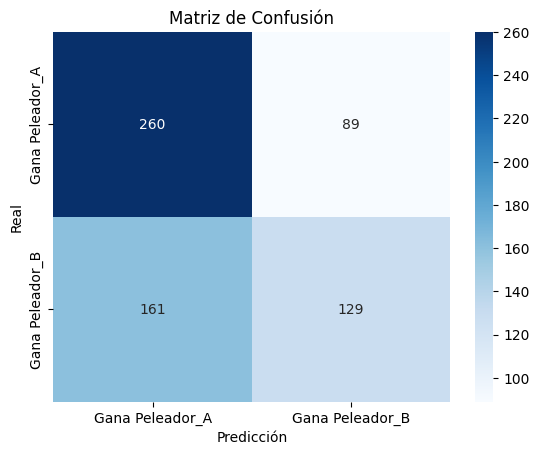

In [ ]:
print("-- Métricas del modelo de regresión logística con hiperparámetros ajustados --")

print("Accuracy:", accuracy_score(y_test_rl, y_pred_rl))
y_prob_rl = rl.predict_proba(X_test_rl)[:,1]
f1_test = f1_score(y_test_rl, y_pred_rl)
roc_auc_test = roc_auc_score(y_test_rl, y_prob_rl)
precision_test = precision_score(y_test_rl, y_pred_rl)
recall_test = recall_score(y_test_rl, y_pred_rl)
log_loss_test = log_loss(y_test_rl,y_prob_rl)
print(f"F1-Score: {f1_test:.4f}")
print(f"AUC-ROC: {roc_auc_test:.4f}")
print(f"Precisión: {precision_test:.4f}")
print(f"Sensibilidad: {recall_test:.4f}")
print(f"Log-loss: {log_loss_test}")
print(confusion_matrix(y_test_rl, y_pred_rl))

cm = confusion_matrix(y_test_rl, y_pred_rl)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Gana Peleador_A', 'Gana Peleador_B'], yticklabels=['Gana Peleador_A', 'Gana Peleador_B'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Regresión logística')
plt.show()

## COMPARACIÓN

En esta parte vamos a comparar los modelos de arriba.

In [ ]:
print("Reporte de clasificación baseline:")
print(classification_report(y_test_baseline, y_pred_baseline)) #lo pongo en un recuadro diferente al resto porque me trunca el output si lo pongo junto

Reporte de clasificación baseline:
              precision    recall  f1-score   support

       False       0.58      0.62      0.60       349
        True       0.51      0.46      0.48       290

    accuracy                           0.55       639
   macro avg       0.54      0.54      0.54       639
weighted avg       0.55      0.55      0.55       639



In [131]:
print("Reporte de clasificación árbol de decisión:")
print(classification_report(y_test_arbol, y_pred_arbol))
print("Reporte de clasificación xgboost:")
print(classification_report(y_test_xgboost, y_pred_xgboost))
print("Reporte de clasificación regresión logística:")
print(classification_report(y_test_rl, y_pred_rl), flush = True) 

Reporte de clasificación árbol de decisión:
              precision    recall  f1-score   support

       False       0.55      0.68      0.61       349
        True       0.47      0.34      0.39       290

    accuracy                           0.53       639
   macro avg       0.51      0.51      0.50       639
weighted avg       0.52      0.53      0.51       639

Reporte de clasificación xgboost:
              precision    recall  f1-score   support

       False       0.63      0.59      0.61       349
        True       0.54      0.58      0.56       290

    accuracy                           0.58       639
   macro avg       0.58      0.58      0.58       639
weighted avg       0.59      0.58      0.58       639

Reporte de clasificación regresión logística:
              precision    recall  f1-score   support

       False       0.62      0.74      0.68       349
        True       0.59      0.44      0.51       290

    accuracy                           0.61       639
   m

In [109]:
print("-- Métricas del modelo base con hiperparámetros ajustados --")
print("Accuracy:", accuracy_score(y_test_baseline, y_pred_baseline))
f1_test = f1_score(y_test_baseline, y_pred_baseline)
roc_auc_test = roc_auc_score(y_test_baseline, y_pred_baseline)
precision_test = precision_score(y_test_baseline, y_pred_baseline)
recall_test = recall_score(y_test_baseline, y_pred_baseline)
log_loss_test = log_loss(y_test_baseline,y_test_baseline)
print(f"F1-Score: {f1_test:.4f}")
print(f"AUC-ROC: {roc_auc_test:.4f}")
print(f"Precisión: {precision_test:.4f}")
print(f"Sensibilidad: {recall_test:.4f}")
print(f"Log-loss: {log_loss_test}")
print(confusion_matrix(y_test_baseline, y_pred_baseline))

-- Métricas del modelo base con hiperparámetros ajustados --
Accuracy: 0.5508607198748043
F1-Score: 0.4829
AUC-ROC: 0.5434
Precisión: 0.5057
Sensibilidad: 0.4621
Log-loss: 2.220446049250313e-16
[[218 131]
 [156 134]]


In [134]:
print("-- Métricas del árbol de decisión con hiperparámetros ajustados --")
y_prob_arbol = arbol.predict_proba(X_test_arbol)[:,1]
print("Accuracy:", accuracy_score(y_test_arbol, y_pred_arbol))
f1_test = f1_score(y_test_arbol, y_pred_arbol)
roc_auc_test = roc_auc_score(y_test_arbol, y_prob_arbol)
precision_test = precision_score(y_test_arbol, y_pred_arbol)
recall_test = recall_score(y_test_arbol, y_pred_arbol)
log_loss_test = log_loss(y_test_arbol,y_prob_arbol)
print(f"F1-Score: {f1_test:.4f}")
print(f"AUC-ROC: {roc_auc_test:.4f}")
print(f"Precisión: {precision_test:.4f}")
print(f"Sensibilidad: {recall_test:.4f}")
print(f"Log-loss: {log_loss_test}")

print("--------------------------")

print("-- Métricas del modelo de xgboost con hiperparámetros ajustados --")

print("Accuracy:", accuracy_score(y_test_xgboost, y_pred_xgboost))
y_prob_xgboost = xgboost.predict_proba(X_test_xgboost)[:,1]
f1_test = f1_score(y_test_xgboost, y_pred_xgboost)
roc_auc_test = roc_auc_score(y_test_xgboost, y_prob_xgboost)
precision_test = precision_score(y_test_xgboost, y_pred_xgboost)
recall_test = recall_score(y_test_xgboost, y_pred_xgboost)
log_loss_test = log_loss(y_test_xgboost,y_prob_xgboost)
print(f"F1-Score: {f1_test:.4f}")
print(f"AUC-ROC: {roc_auc_test:.4f}")
print(f"Precisión: {precision_test:.4f}")
print(f"Sensibilidad: {recall_test:.4f}")
print(f"Log-loss: {log_loss_test}")

print("--------------------------")

print("-- Métricas del modelo de regresión logística con hiperparámetros ajustados --")

print("Accuracy:", accuracy_score(y_test_rl, y_pred_rl))
y_prob_rl = rl.predict_proba(X_test_rl)[:,1]
f1_test = f1_score(y_test_rl, y_pred_rl)
roc_auc_test = roc_auc_score(y_test_rl, y_prob_rl)
precision_test = precision_score(y_test_rl, y_pred_rl)
recall_test = recall_score(y_test_rl, y_pred_rl)
log_loss_test = log_loss(y_test_rl,y_prob_rl)
print(f"F1-Score: {f1_test:.4f}")
print(f"AUC-ROC: {roc_auc_test:.4f}")
print(f"Precisión: {precision_test:.4f}")
print(f"Sensibilidad: {recall_test:.4f}")
print(f"Log-loss: {log_loss_test}")

-- Métricas del árbol de decisión con hiperparámetros ajustados --
Accuracy: 0.5258215962441315
F1-Score: 0.3928
AUC-ROC: 0.5383
Precisión: 0.4689
Sensibilidad: 0.3379
Log-loss: 0.7004803201475847
--------------------------
-- Métricas del modelo de xgboost con hiperparámetros ajustados --
Accuracy: 0.5837245696400626
F1-Score: 0.5581
AUC-ROC: 0.6131
Precisión: 0.5385
Sensibilidad: 0.5793
Log-loss: 0.6754048219019672
--------------------------
-- Métricas del modelo de regresión logística con hiperparámetros ajustados --
Accuracy: 0.6087636932707355
F1-Score: 0.5079
AUC-ROC: 0.6291
Precisión: 0.5917
Sensibilidad: 0.4448
Log-loss: 0.6612155179196354


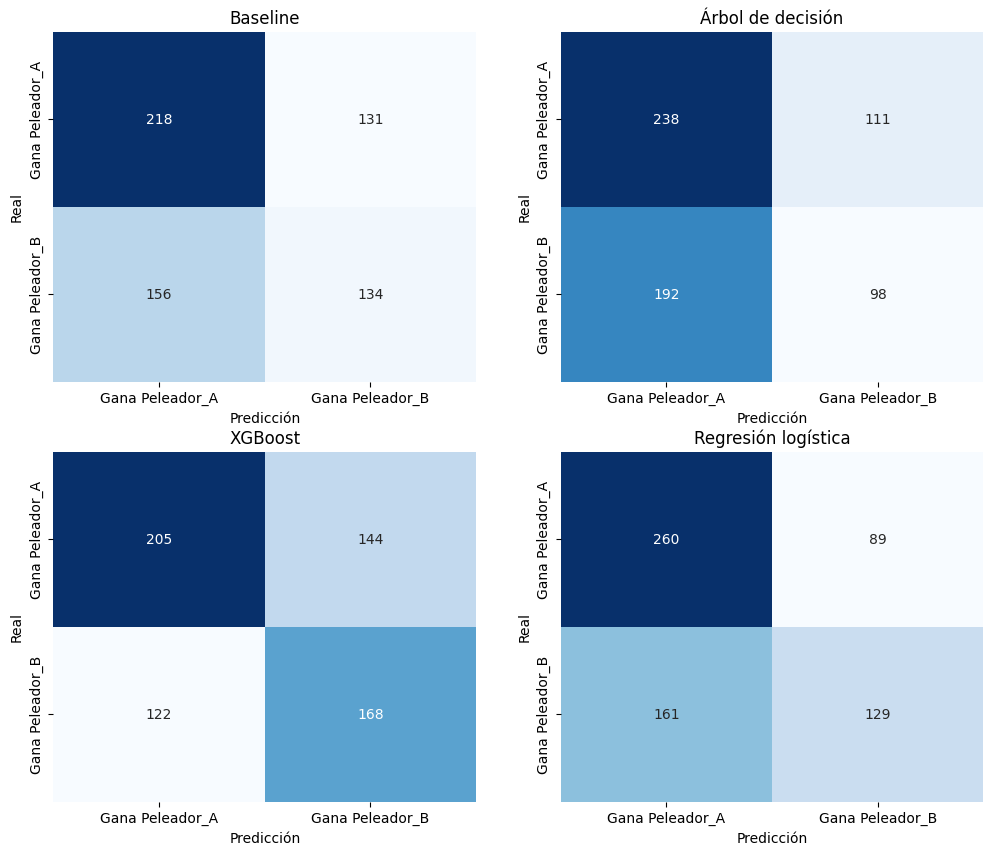

In [125]:
# Configurar el tamaño de la figura
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 filas, 2 columnas

# Definir títulos y datos de los modelos
titulos = ["Baseline", "Árbol de decisión", "XGBoost", "Regresión logística"]
y_tests = [y_test_baseline, y_test_arbol, y_test_xgboost, y_test_rl]
y_preds = [y_pred_baseline, y_pred_arbol, y_pred_xgboost, y_pred_rl]

# Generar las matrices de confusión en los subgráficos
for ax, title, y_test, y_pred in zip(axes.flat, titulos, y_tests, y_preds):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Gana Peleador_A', 'Gana Peleador_B'], 
                yticklabels=['Gana Peleador_A', 'Gana Peleador_B'], ax=ax, cbar = False)
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Real')
    ax.set_title(title)
    
plt.show()